In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
shearfac = 0.71 # monthly: 0.55 mm / unit shear
tcwvfac = 3.12 # % 0.39%    3.1 % / unit tcw
tcabsfac = 1.22 # spread 0.1    1.2 mm / unit tcw

mmPerPercent = tcabsfac/tcwvfac

In [15]:
shmodel = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc')
tmodel = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc')

In [19]:
xr.open_dataarray(shmodel[0]).model_id

'HadGEM2-ES'

In [20]:
for ids, sh in enumerate(shmodel):
    print(xr.open_dataarray(sh).model_id, xr.open_dataarray(tmodel[ids]).model_id)
    print(xr.open_dataarray(sh).model_id == xr.open_dataarray(tmodel[ids]).model_id)

HadGEM2-ES bcc-csm1-1
False
bcc-csm1-1 CCSM4
False
CCSM4 CNRM-CM5
False
CNRM-CM5 CSIRO-Mk3-6-0
False
CSIRO-Mk3-6-0 GISS-E2-H
False
GISS-E2-H GISS-E2-R
False
GISS-E2-R IPSL-CM5A-LR
False
IPSL-CM5A-LR MPI-ESM-LR
False
MPI-ESM-LR MRI-ESM1
False
IPSL-CM5B-LR NorESM1-ME
False
MIROC-ESM-CHEM NorESM1-M
False
MIROC-ESM FGOALS-g2
False
MIROC5 GFDL-CM3
False
MPI-ESM-MR GFDL-ESM2G
False
MRI-CGCM3 GFDL-ESM2M
False
MRI-ESM1 GISS-E2-H-CC
False
NorESM1-ME GISS-E2-R-CC
False
NorESM1-M HadGEM2-CC
False
HadGEM2-CC inmcm4
False
CanESM2 IPSL-CM5A-MR
False
IPSL-CM5A-MR IPSL-CM5B-LR
False
FGOALS-g2 MIROC-ESM-CHEM
False
ACCESS1-0 MIROC-ESM
False
ACCESS1-3 MIROC5
False
bcc-csm1-1-m MPI-ESM-MR
False
BNU-ESM ACCESS1-0
False
CESM1-BGC CanESM2
False
CESM1-CAM5 FIO-ESM
False
CMCC-CESM MRI-CGCM3
False
CMCC-CMS HadGEM2-ES
False
CMCC-CM ACCESS1-3
False
FIO-ESM bcc-csm1-1-m
False
GFDL-CM3 BNU-ESM
False
GFDL-ESM2G CESM1-BGC
False
GFDL-ESM2M CESM1-CAM5
False
GISS-E2-H-CC CMCC-CESM
False
GISS-E2-R-CC CMCC-CMS
False
inmcm

Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [28]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
#cmip_tcw_map = uda.shift_lons(cmip_tcw_map)

In [29]:
cmip_tcw_map.model_name

<xarray.DataArray 'model_name' (model_name: 38)>
array(['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5',
       'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
       'CanESM2', 'FGOALS-g2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G',
       'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC',
       'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR',
       'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR',
       'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME',
       'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4'], dtype=object)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'

In [6]:
cmip_shear_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc', concat_dim='model', combine='nested').load()
#cmip_tcw_map = uda.shift_lons(cmip_tcw_map)

In [12]:
cmip_shear_map.isel(model=1).plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

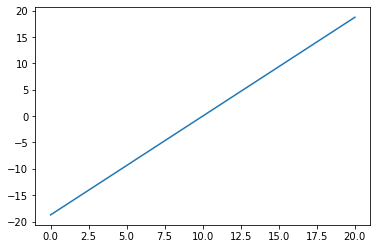

In [6]:
plt.plot(cmip_tcw_map.lon)

In [7]:
cmip_sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua*.nc', concat_dim='model', combine='nested').load()
#cmip_sh_map = uda.shift_lons(cmip_sh_map)

In [8]:
cmip_sh_map

<xarray.Dataset>
Dimensions:       (lat: 25, lon: 21, model: 38)
Coordinates:
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon           (lon) float64 -18.75 -16.88 -15.0 -13.12 ... 15.0 16.88 18.75
    month_number  int64 8
    time          (model) object 1975-02-16 00:00:00 ... 1975-02-14 18:00:00
    year          int64 1974
Dimensions without coordinates: model
Data variables:
    unknown       (model, lat, lon) float64 3.575 3.608 3.592 ... nan nan nan

In [9]:
cmip_sh_wa = cmip_sh_map['unknown'].sel(lon=slice(-18,25), lat=slice(3.5,25)).load()*shearfac

In [10]:
cmip_tcw_wa = cmip_tcw_map['prw'].sel(lon=slice(-18,25), lat=slice(3.5,25)).load()*tcabsfac

In [11]:
cmip_both = cmip_tcw_wa + cmip_sh_wa

In [12]:
# 10,90 perc tcw model CSIRO-Mk3-6-0 ACCESS1-0
# 2040 10,90 perc shear model CESM1-CAM5 MIROC-ESM-CHEM
# 10,90 perc shear+tcw model CSIRO-Mk3-6-0 HadGEM2-ES
# 10,90 perc tcw model GFDL-ESM2M IPSL-CM5A-MR
# 2060 10,90 perc shear model CSIRO-Mk3-6-0 ACCESS1-0
# 10,90 perc shear+tcw model GFDL-ESM2M HadGEM2-ES
# 10,90 perc tcw model GISS-E2-R CMCC-CMS
# 2080 10,90 perc shear model FGOALS-g2 ACCESS1-0
# 10,90 perc shear+tcw model GISS-E2-R HadGEM2-CC


In [13]:
perc_dic = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "rb"))

In [14]:
perc_dic

{'2040': {'tcw': ('CSIRO-Mk3-6-0', 'ACCESS1-0'),
  'shear': ('CESM1-CAM5', 'MIROC-ESM-CHEM'),
  'shear+tcw': ('CSIRO-Mk3-6-0', 'HadGEM2-ES')},
 '2060': {'tcw': ('GFDL-ESM2M', 'IPSL-CM5A-MR'),
  'shear': ('CSIRO-Mk3-6-0', 'ACCESS1-0'),
  'shear+tcw': ('GFDL-ESM2M', 'HadGEM2-ES')},
 '2080': {'tcw': ('GISS-E2-R', 'CMCC-CMS'),
  'shear': ('FGOALS-g2', 'ACCESS1-0'),
  'shear+tcw': ('GISS-E2-R', 'HadGEM2-CC')}}

In [15]:
def draw_map(ax, dat, lat, lon, title='', levels=None, cbarlabel='', cmap=''):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap=cmap, extend='both', levels=levels, alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.contour(lon, lat, dat, transform=ccrs.PlateCarree(), colors='white', levels=levels, linewidths=0.1)
    ax.coastlines()
    # Gridlines
#     xl = ax.gridlines(draw_labels=True, linestyle='dotted', linewidths=0.5);
#     xl.top_labels = False
#     xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.title(title)


In [ ]:
f = plt.figure(figsize=(10,11), dpi=200)

for num, model in enumerate(['2040','2080']):
    
    mm = perc_dic[model]
    for ids, m in enumerate(mm['shear+tcw']):
        #ipdb.set_trace()
    
        file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+model+'/prw_2006*_'+m+'*.nc')
        tcw_map = xr.open_dataset(file[0])
        shfile = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+model+'/ua*_'+m+'*.nc')
        sh_map = xr.open_dataset(shfile[0])

        cmip_tcw_wa = tcw_map['prw']
        cmip_sh_wa = sh_map['unknown']

        cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*tcabsfac / mmPerPercent
        cmip_sh_wa = cmip_sh_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*shearfac / mmPerPercent

        both = cmip_sh_wa / (cmip_tcw_wa+cmip_sh_wa) *100 

        posi = num+1
        
        if num==1:
            numx = 4
        else:
            numx =0
            
        if ids > 0:
            ti = 1
            tag = '90'
        else:
            ti = 0
            tag = '10'
            
        xx = (numx)+(ids+1)+ti
        xxx = (numx)+(ids+2)+ti
        
        # Create a Rectangle patch
        rect = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')

        # Add the patch to the Axes
        
        
        print(xx, xxx)

        ax = f.add_subplot(4,2,xx, projection=ccrs.PlateCarree())
        ax.set_ylim(4,25)
        ax.set_facecolor('lightgrey')
        ax.add_patch(rect)
        draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
        
        ax1 = f.add_subplot(4,2,xxx, projection=ccrs.PlateCarree())
        ax1.set_ylim(4,25)
        ax1.set_facecolor('lightgrey')
        rect1 = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')
        ax1.add_patch(rect1)
        draw_map(ax1, both, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile shear contribution', levels=np.arange(0,20,1), cbarlabel='%', cmap='YlOrBr')  

plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.52

plt.annotate(text[0], xy=(x1, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[6], xy=(x1, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[7], xy=(x2, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall.jpg')

In [16]:
model_names = []
for mods in glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc'):
    tcw_map = xr.open_dataset(mods)
    model_names.append(tcw_map['prw'].attrs['model_id'])

1 2
3 4
5 6
7 8


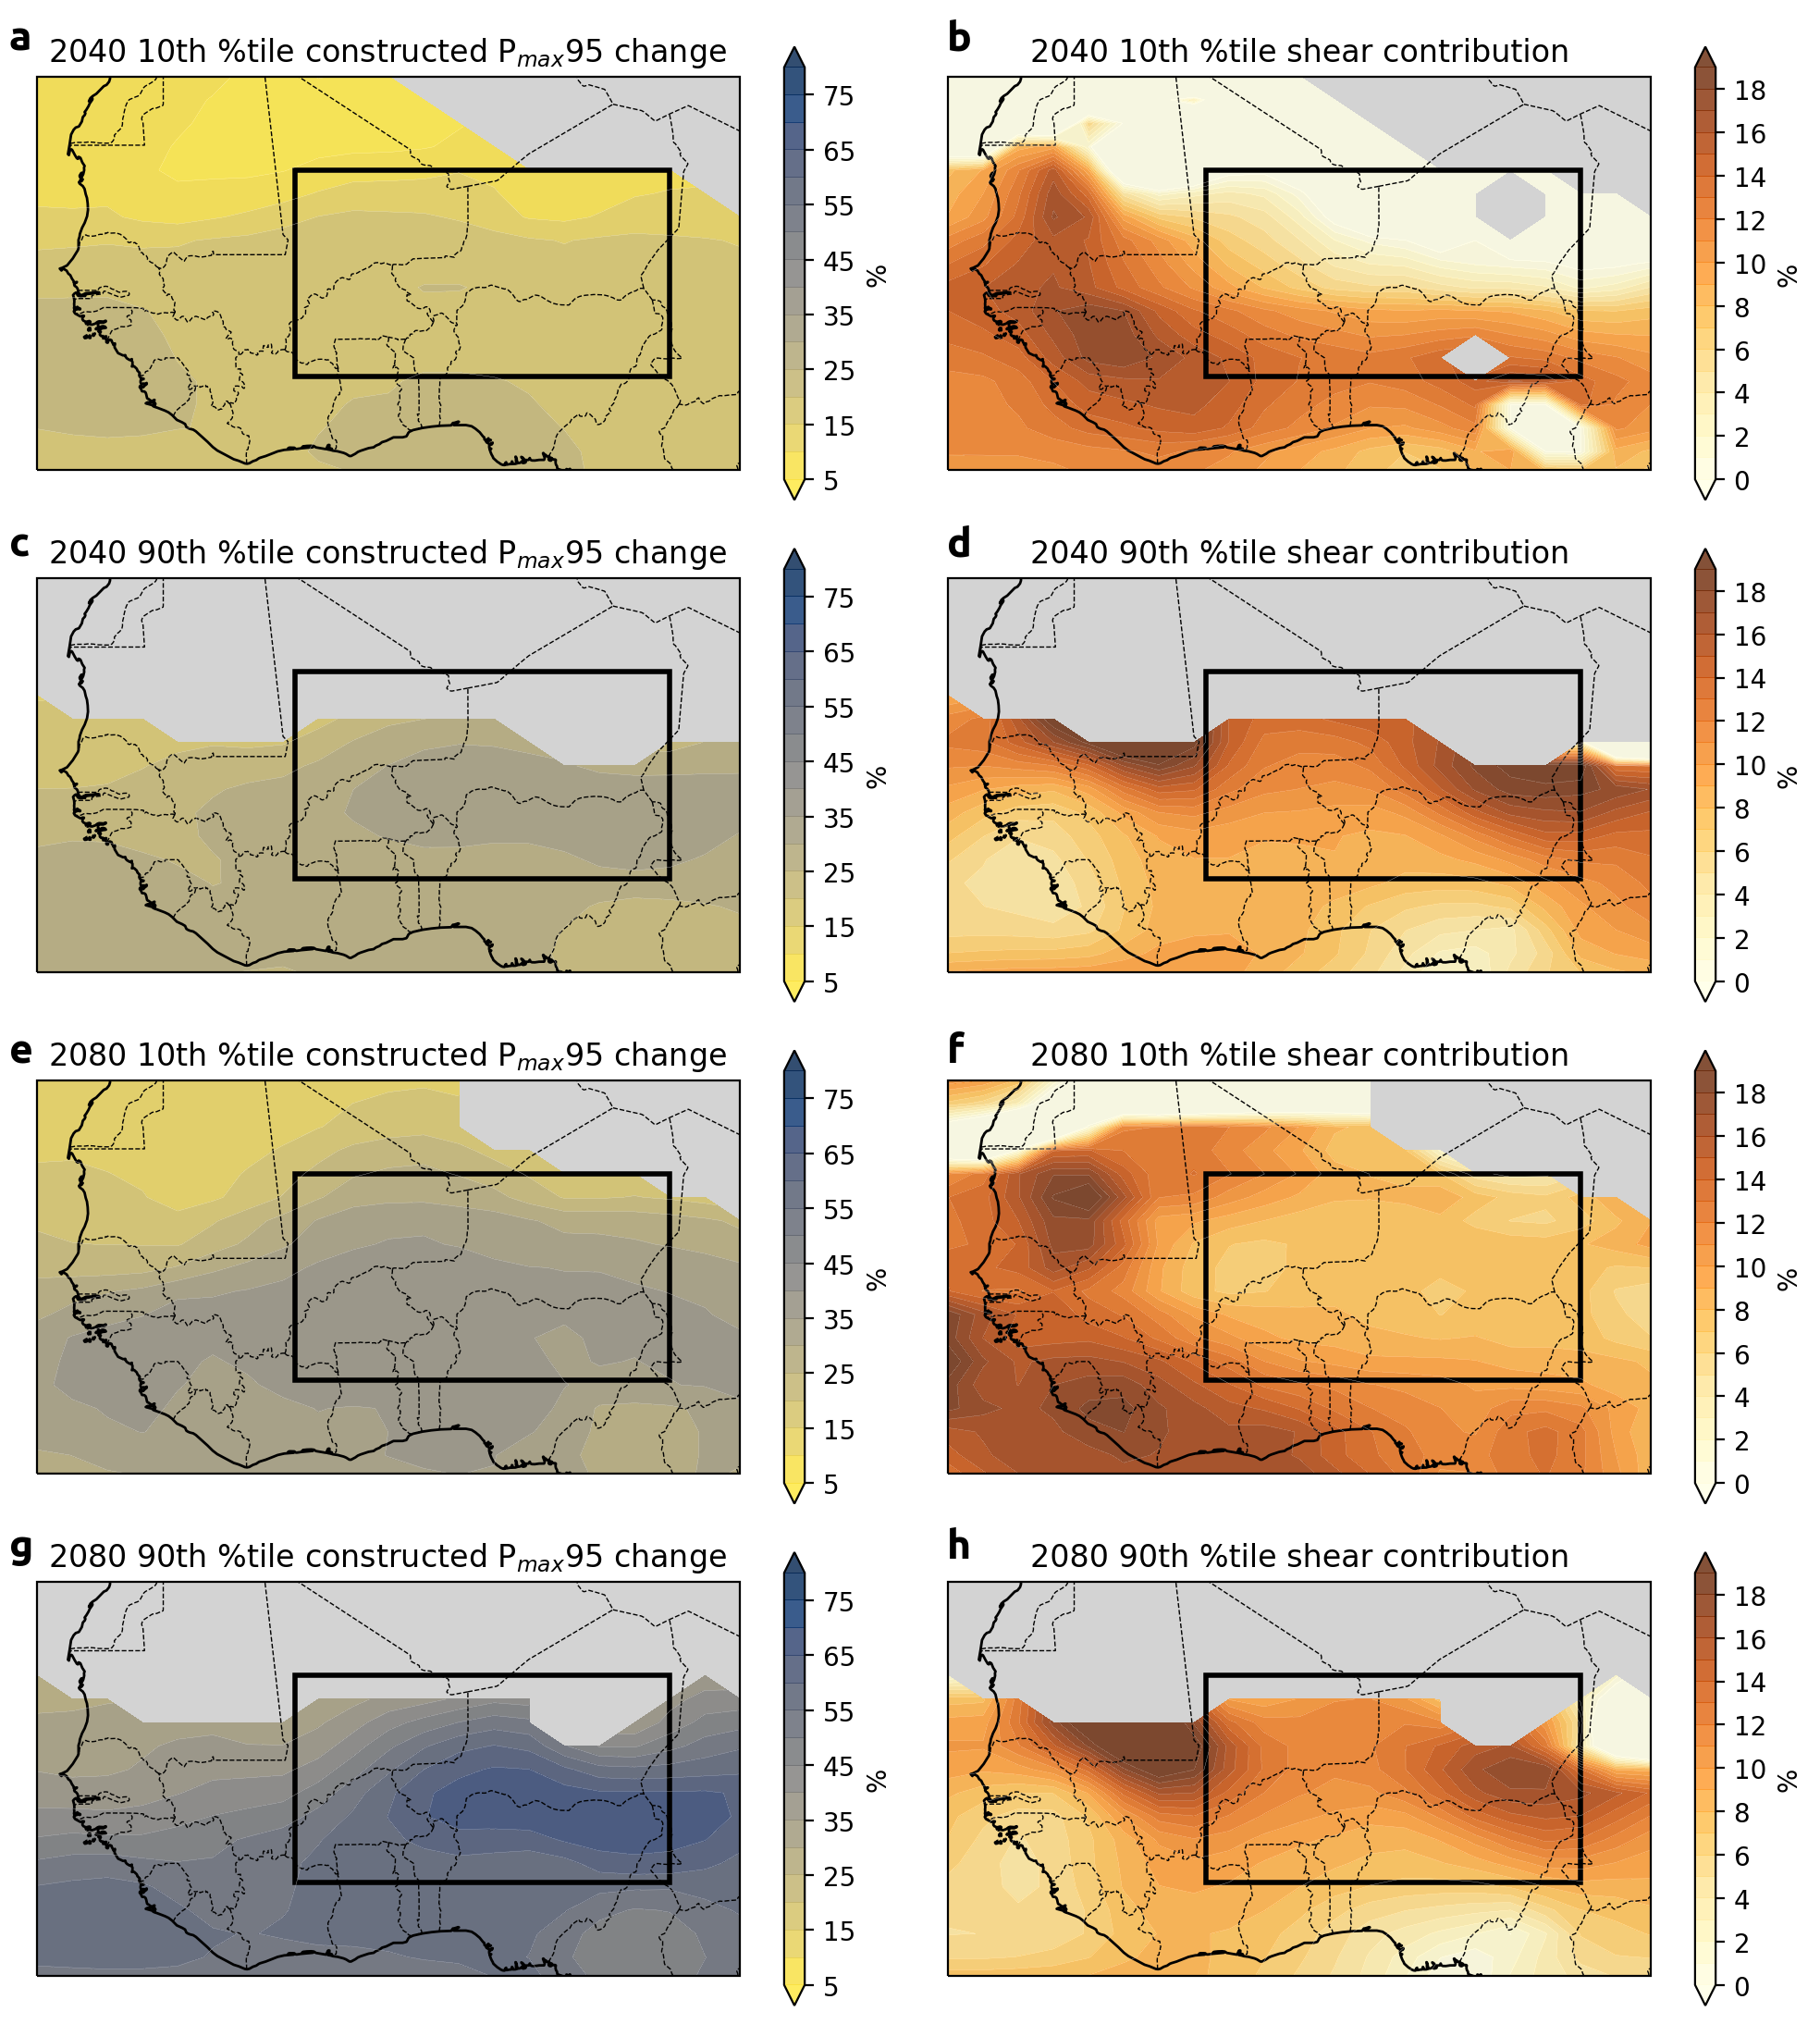

In [17]:
f = plt.figure(figsize=(10,11), dpi=200)

for num, model in enumerate(['2040','2080']):
    
    mm = perc_dic[model]
    for ids, m in enumerate(mm['shear+tcw']):
        #ipdb.set_trace()
    
        file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+model+'/prw_2006*_'+m+'*.nc')
        tcw_map = xr.open_dataset(file[0])
        shfile = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+model+'/ua*_'+m+'*.nc')
        sh_map = xr.open_dataset(shfile[0])

        cmip_tcw_wa = tcw_map['prw']
        cmip_sh_wa = sh_map['unknown']

        cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*tcabsfac / mmPerPercent
        cmip_sh_wa = cmip_sh_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*shearfac / mmPerPercent

        both = cmip_sh_wa / (cmip_tcw_wa+cmip_sh_wa) *100 

        posi = num+1
        
        if num==1:
            numx = 4
        else:
            numx =0
            
        if ids > 0:
            ti = 1
            tag = '90'
        else:
            ti = 0
            tag = '10'
            
        xx = (numx)+(ids+1)+ti
        xxx = (numx)+(ids+2)+ti
        
        # Create a Rectangle patch
        rect = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')

        # Add the patch to the Axes
        
        
        print(xx, xxx)

        ax = f.add_subplot(4,2,xx, projection=ccrs.PlateCarree())
        ax.set_ylim(4,25)
        ax.set_facecolor('lightgrey')
        ax.add_patch(rect)
        draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
        
        ax1 = f.add_subplot(4,2,xxx, projection=ccrs.PlateCarree())
        ax1.set_ylim(4,25)
        ax1.set_facecolor('lightgrey')
        rect1 = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')
        ax1.add_patch(rect1)
        draw_map(ax1, both, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile shear contribution', levels=np.arange(0,20,1), cbarlabel='%', cmap='YlOrBr')  

plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.52

plt.annotate(text[0], xy=(x1, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[6], xy=(x1, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[7], xy=(x2, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall.jpg')

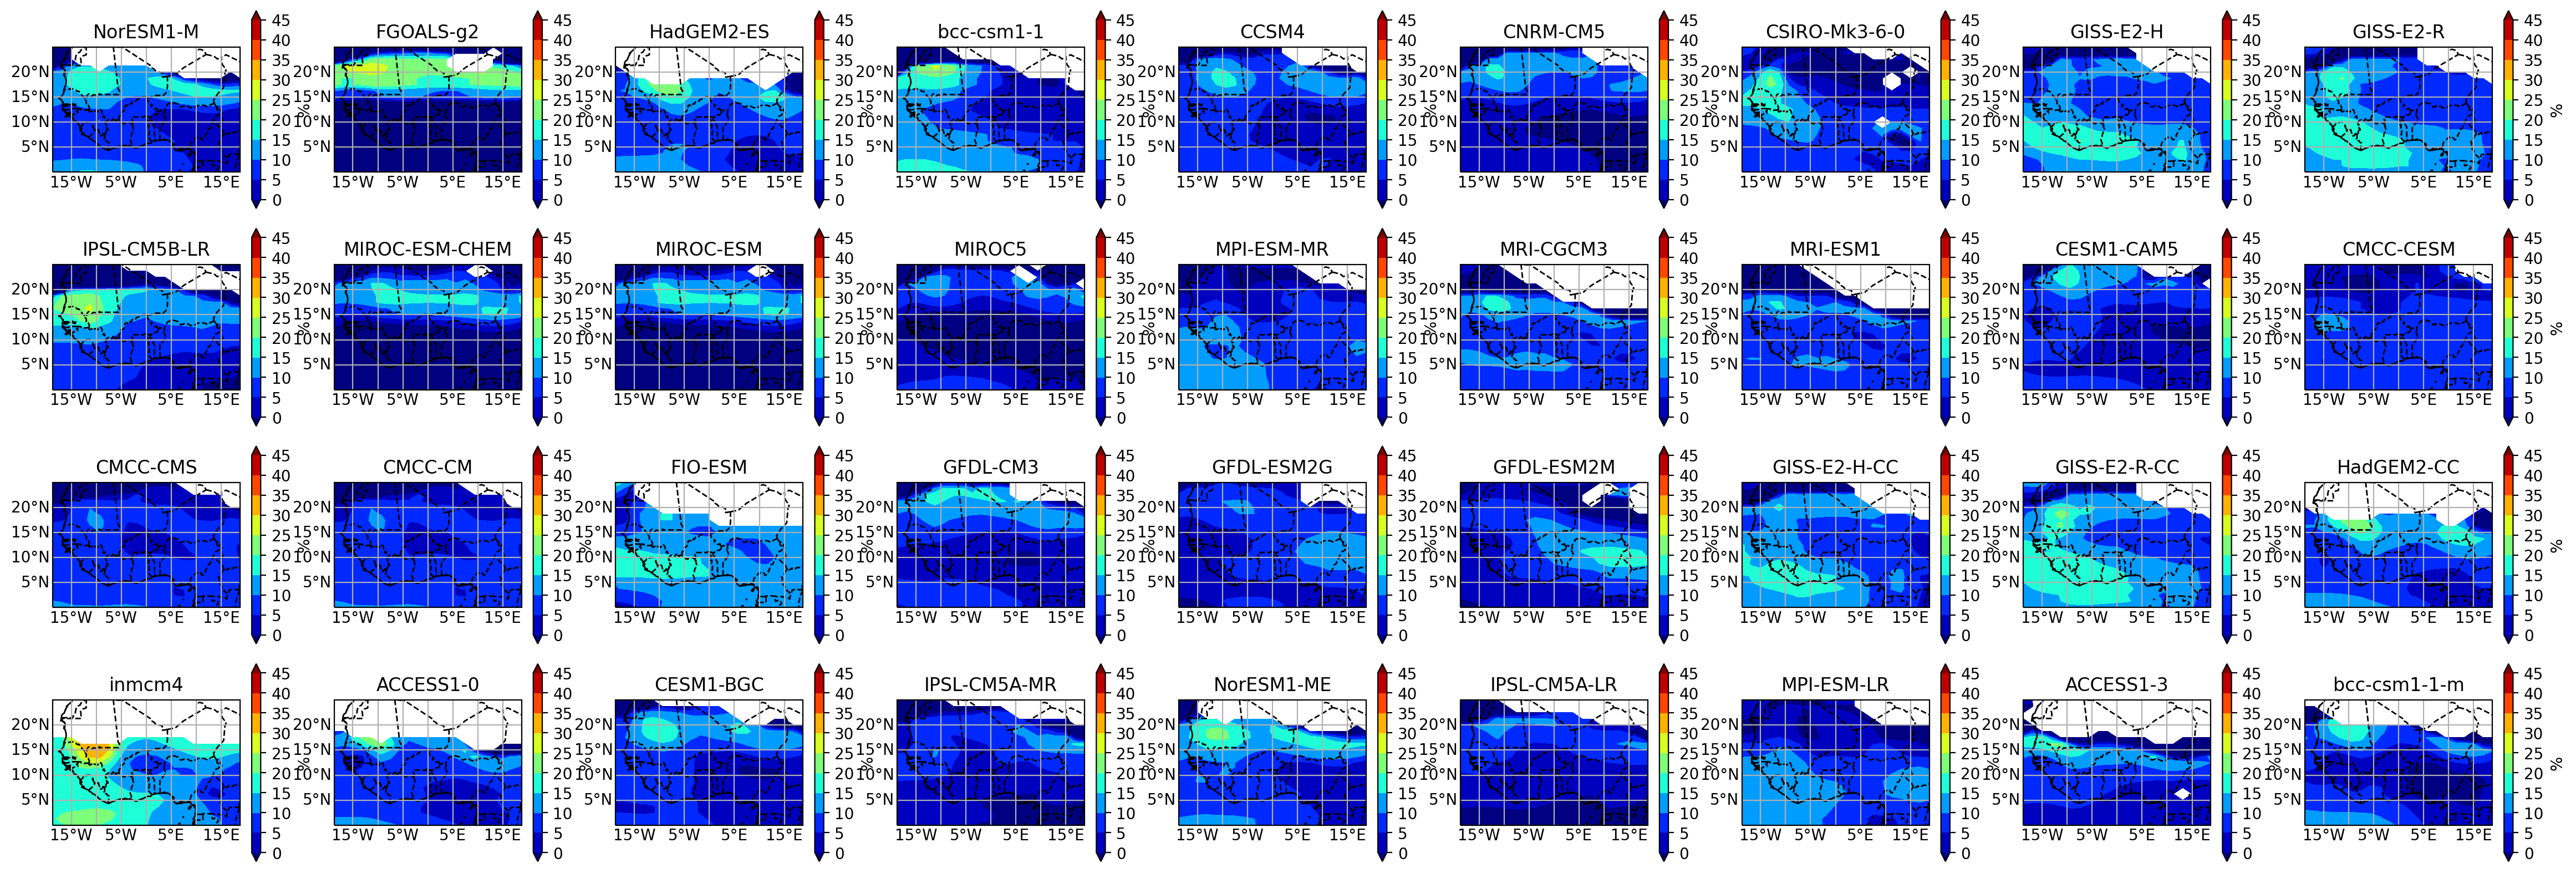

In [18]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'%')

f = plt.figure(figsize=(23,8), dpi=200)

for num, model in enumerate(model_names[0:36]):
  
    file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_2006*_'+model+'*.nc')
    tcw_map = xr.open_dataset(file[0])
    shfile = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua*_'+model+'*.nc')
    sh_map = xr.open_dataset(shfile[0])

    cmip_tcw_wa = tcw_map['prw']
    cmip_sh_wa = sh_map['unknown']

    cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(0,25))*tcabsfac
    cmip_sh_wa = cmip_sh_wa.sel(lon=slice(-20,20), lat=slice(0,25))*shearfac
    
    both = cmip_sh_wa / (cmip_tcw_wa+cmip_sh_wa) *100
    posi = num+1
       
    ax = f.add_subplot(4,9,posi, projection=ccrs.PlateCarree())
    ax.set_ylim(0,25)
    
    draw_map(ax, both, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model, levels=np.arange(0,50,5))   #[num,:,:]

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/shearContribution_shear+tcw.png')